In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/actigraphydata/CleanedActigraphyData.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load the training data
train = pd.read_csv(base_path)
train.head(5)

,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,activity_level,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,Medium,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,Medium,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,Low,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,Low,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,Low,0.0


In [2]:
# Drop rows with specific participant IDs
train = train[~train['participant_id'].isin(['ab16a20d', 'db38d1f9'])]
train = train.drop(columns=['activity_level'])
# Check the dataset after removing the rows
train.head()


,participant_id,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,sii
0,00115b9f,0.020411,0.001761,0.022853,0.018667,1.020398,0.001759,0.000000,0.000000,1.0
1,001f3379,0.013445,0.031016,2.952888,0.000000,0.996000,0.049507,3.763106,48.399446,1.0
2,00f332d1,0.029802,0.104216,3.681586,0.000000,0.980751,0.070811,15.596860,11.175805,1.0
3,01085eb3,0.035465,0.085573,2.506849,0.000000,0.969044,0.082127,4.349319,0.000000,0.0
4,012cadd8,0.061621,0.202441,6.307294,0.000000,0.966942,0.135903,8.530412,0.000000,0.0


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the data into 90% training and 10% testing
train, test = train_test_split(train, test_size=0.05, random_state=42)

# Save the test set to a CSV file
test.to_csv('/kaggle/working/actigraphytest_data.csv', index=False)

# Check the resulting DataFrames
print("Train dataset (95%):")
print(train.head())

print("\nTest dataset (5%):")
print(test.head())


Train dataset (95%):
    participant_id  mean_enmo  std_enmo  max_enmo  min_enmo  mean_magnitude  \
737       be210bc7   0.001530  0.008972  0.727582  0.000000        0.973546   
598       9c1ea003   0.039073  0.103140  3.619822  0.000000        0.962661   
810       d05f5d71   0.016894  0.047983  2.766307  0.000000        0.981501   
551       8f753551   0.031791  0.028368  0.102840  0.004501        0.899569   
791       cb2752bc   0.018958  0.051097  2.053755  0.000000        0.983313   

     std_magnitude  inactivity_percentage  non_wear_percentage  sii  
737       0.022613              71.124532            80.425655  2.0  
598       0.089478              11.911023             7.273136  1.0  
810       0.066992               9.358126             1.028595  2.0  
551       0.129376               0.000000             0.000000  0.0  
791       0.059103              11.419001            39.074887  1.0  

Test dataset (5%):
    participant_id  mean_enmo  std_enmo  max_enmo  min_enmo  mea

In [4]:
test.shape

(50, 10)

In [5]:
# Drop the 'activity_level' column as it was introduced to understand the data
train = train.drop(columns=['participant_id'])

In [6]:
train.head()

,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage,sii
737,0.001530,0.008972,0.727582,0.000000,0.973546,0.022613,71.124532,80.425655,2.0
598,0.039073,0.103140,3.619822,0.000000,0.962661,0.089478,11.911023,7.273136,1.0
810,0.016894,0.047983,2.766307,0.000000,0.981501,0.066992,9.358126,1.028595,2.0
551,0.031791,0.028368,0.102840,0.004501,0.899569,0.129376,0.000000,0.000000,0.0
791,0.018958,0.051097,2.053755,0.000000,0.983313,0.059103,11.419001,39.074887,1.0


Feature Variances:
 mean_enmo                  0.000612
std_enmo                   0.003223
max_enmo                   3.575885
min_enmo                   0.000030
mean_magnitude             0.001841
std_magnitude              0.003172
inactivity_percentage    222.872139
non_wear_percentage      735.978464
dtype: float64


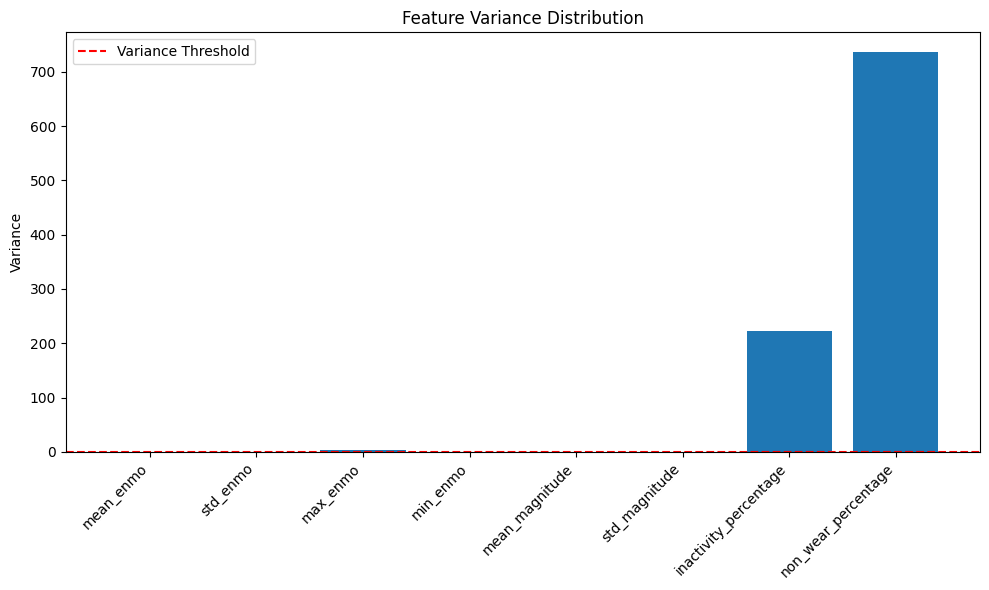

Classification Report (No Resampling):
              precision    recall  f1-score   support

         0.0       0.66      0.45      0.54       166
         1.0       0.35      0.33      0.34        75
         2.0       0.17      0.28      0.21        40
         3.0       0.00      0.00      0.00         3

    accuracy                           0.39       284
   macro avg       0.30      0.27      0.27       284
weighted avg       0.50      0.39      0.43       284

Classification Report (With Resampling):
              precision    recall  f1-score   support

         0.0       0.65      0.40      0.50       166
         1.0       0.38      0.25      0.30        75
         2.0       0.18      0.33      0.23        40
         3.0       0.02      0.33      0.03         3

    accuracy                           0.35       284
   macro avg       0.31      0.33      0.27       284
weighted avg       0.51      0.35      0.40       284

Confusion Matrix (No Resampling):
[[75 36 31 24]
 

In [7]:
X = train.drop(columns=['sii'])
y = train['sii']

# Initial Feature Variance Analysis
feature_variances = np.var(X, axis=0)
print("Feature Variances:\n", feature_variances)

selected_features = feature_variances.index
X_high_variance = X[selected_features]
variance_threshold=0.1
# Plotting Feature Variances
plt.figure(figsize=(10, 6))
plt.bar(feature_variances.index, feature_variances.values)
plt.axhline(y=variance_threshold, color='r', linestyle='--', label="Variance Threshold")
plt.xticks(rotation=45, ha="right")
plt.title("Feature Variance Distribution")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_high_variance)

# PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_2d, y, test_size=0.3, random_state=42, stratify=y
)


# Model without resampling
svm_model_no_resample = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model_no_resample.fit(X_train, y_train)
y_pred_no_resample = svm_model_no_resample.predict(X_test)

# Model with SMOTE-Tomek resampling
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
svm_model_with_resample = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model_with_resample.fit(X_resampled, y_resampled)
y_pred_with_resample = svm_model_with_resample.predict(X_test)

# Step 9: Evaluate the models (e.g., using classification report and confusion matrix)
print("Classification Report (No Resampling):")
print(classification_report(y_test, y_pred_no_resample))

print("Classification Report (With Resampling):")
print(classification_report(y_test, y_pred_with_resample))

# Optional: Confusion Matrix
print("Confusion Matrix (No Resampling):")
print(confusion_matrix(y_test, y_pred_no_resample))

print("Confusion Matrix (With Resampling):")
print(confusion_matrix(y_test, y_pred_with_resample))


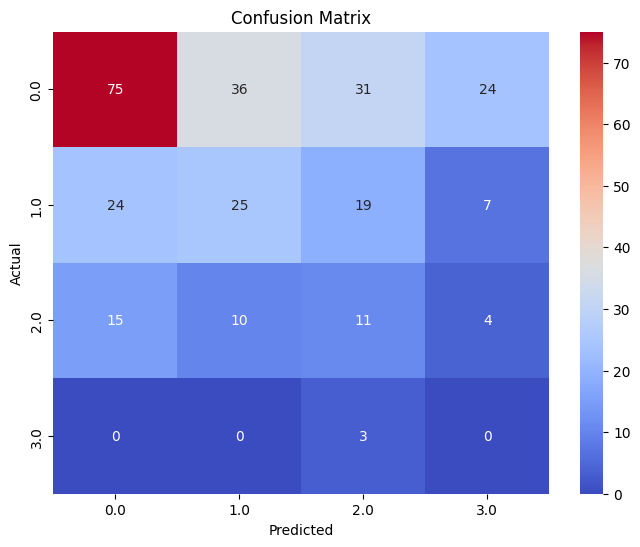

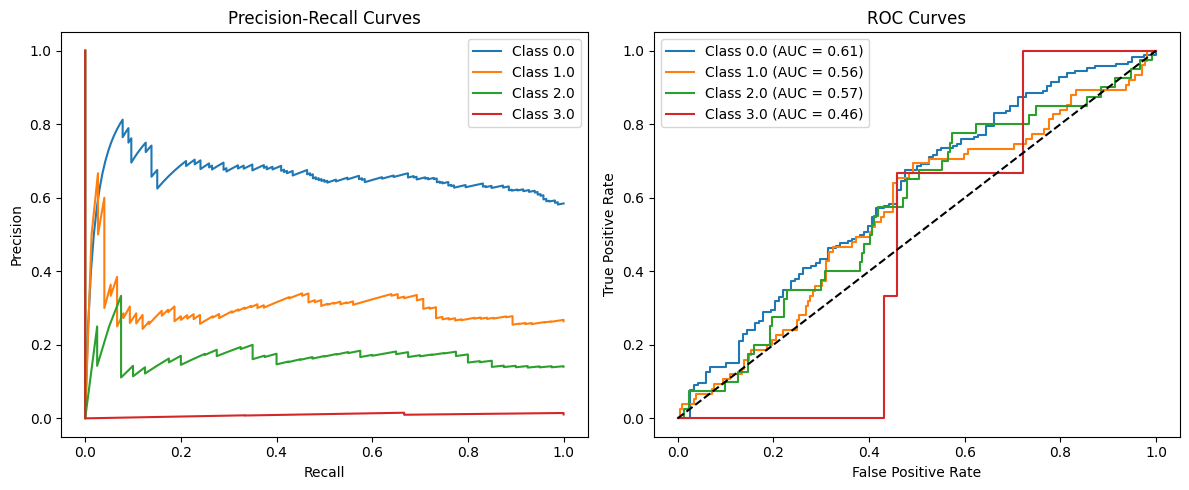

In [8]:
# non-resampled model is the better choice
final_model = svm_model_no_resample
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, fmt='d', cmap="coolwarm", 
    xticklabels=np.unique(y), 
    yticklabels=np.unique(y)
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and Precision-Recall Curves
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

plt.figure(figsize=(12, 5))

# Precision-Recall Curves
plt.subplot(121)
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# ROC Curves
plt.subplot(122)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()



In [9]:
import joblib

path_to_scaler = '/kaggle/working/svm_actigraphydata_scaler.pkl'
path_to_pca = '/kaggle/working/svm_actigraphydata_pca.pkl'
path_to_svm_model = '/kaggle/working/svm_actigraphydata_model.pkl'
path_to_selected_features = '/kaggle/working/svm_actigraphydata_selected_features.pkl'


# Save the trained model to the specified path
joblib.dump(final_model, path_to_svm_model)
joblib.dump(scaler, path_to_scaler)  # Save scaler
joblib.dump(pca_2d, path_to_pca)  # Save PCA
joblib.dump(selected_features, path_to_selected_features)  # Save PCA


['/kaggle/working/svm_actigraphydata_selected_features.pkl']

In [10]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, classification_report

#Load Saved Components
scaler = joblib.load(path_to_scaler)
pca_2d = joblib.load(path_to_pca)
svm_model = joblib.load(path_to_svm_model)
selected_features = joblib.load(path_to_selected_features)

testDfpath = '/kaggle/working/actigraphytest_data.csv'
testdataset = pd.read_csv(testDfpath)

In [11]:
X_test = testdataset[selected_features]
X_test.head()


,mean_enmo,std_enmo,max_enmo,min_enmo,mean_magnitude,std_magnitude,inactivity_percentage,non_wear_percentage
0,0.000188,0.000138,0.000285,0.000090,0.993918,0.000302,0.000000,0.000000
1,0.001912,0.016293,2.242327,0.000000,0.997142,0.016713,11.785322,84.424857
2,0.047706,0.048375,0.094223,0.005745,0.847579,0.232321,0.000000,0.000000
3,0.013404,0.040714,2.255659,0.000000,0.989156,0.057203,2.907148,55.218180
4,0.019259,0.045959,3.970733,0.000000,0.991119,0.056548,3.333910,49.949293


In [12]:
# Scale and Apply PCA (using the saved scaler and PCA)
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca_2d.transform(X_test_scaled)

In [13]:
# Step 4: Make Predictions
y_pred = svm_model.predict(X_test_pca)
y_pred_proba = svm_model.predict_proba(X_test_pca)

predictions_df = pd.DataFrame({
    'id': testdataset['participant_id'],  # Replace with actual id column
    'sii': y_pred
})

In [14]:
predictions_df

,id,sii
0,ef07f833,1.0
1,893293dd,2.0
2,93904b23,0.0
3,a6fbb2e7,2.0
4,f09e7b33,2.0
5,6c0fe935,0.0
6,e28c0bfa,0.0
7,b69bf1f7,0.0
8,2a922ca4,0.0
9,9d1b2d2c,0.0


In [15]:
predictions_df.to_csv('/kaggle/working/actigraphydatapredictions.csv', index=False)

predictions_proba_df = pd.DataFrame(y_pred_proba, columns=[f'Class_{i}_Prob' for i in range(y_pred_proba.shape[1])])
predictions_proba_df.to_csv('/kaggle/working/actigraphydatapredictions_with_probabilities.csv', index=False)